<a href="https://colab.research.google.com/github/nail1021734/stock_example/blob/main/stock_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# 安裝套件
# !pip install yfinance
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install pandas

In [56]:
# 從yahoo股市蒐集資料
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yf
yf.pdr_override()

# 指定公司
stock_name = '2330.TW'
# 指定訓練資料日期範圍 (從20200101開始至今)
start_date = datetime(2020, 1, 1)
end_date = None

# 透過api從yahoo股市下載指定公司資料
data = pdr.get_data_yahoo(stock_name, start=start_date, end=end_date).reset_index()
data.set_index('Date', inplace=True)

# 在colab界面輸出資料
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,332.5,339.0,332.5,339.0,313.791595,31754120
2020-01-03,344.0,345.0,335.5,339.5,314.254364,41811268
2020-01-06,333.0,334.5,332.0,332.0,307.312225,45343057
2020-01-07,332.5,333.0,326.5,329.5,304.998047,50879181
2020-01-08,325.0,333.0,325.0,329.5,304.998047,37567748
...,...,...,...,...,...,...
2023-06-15,590.0,593.0,587.0,591.0,591.000000,27392154
2023-06-16,590.0,590.0,584.0,589.0,589.000000,38128802
2023-06-19,583.0,585.0,582.0,583.0,583.000000,14346885


<Axes: xlabel='Date'>

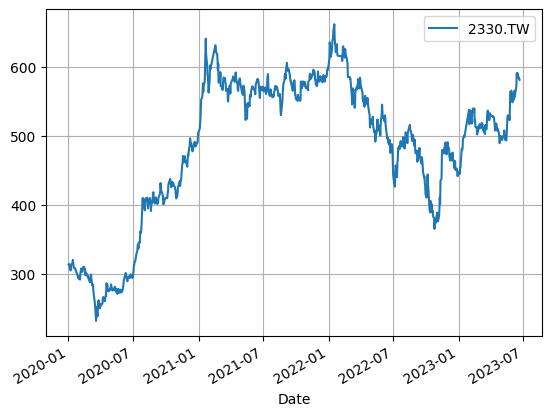

In [57]:
# 在圖表上呈現調整收盤假與日期的變化
data['Adj Close'].plot(label=stock_name, grid=True, legend=True)

In [58]:
import numpy as np

# 用前三天預測後一天
n_day = 3
# 準備訓練模型資料 (用前一天的開盤, 最高, 最低, 收盤, 調整收盤假, 成交量來預測明日的調整收盤假)
x = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']][:-1].to_numpy()
y = data['Adj Close'][n_day:].to_numpy()

tmp_x = []
for i in range(n_day, x.shape[0]+1):
    tmp_x.append(x[i-n_day:i].reshape(-1))

x = np.array(tmp_x)

# 切分資料(75%用於訓練, 25%用於測試)
split_ratio = 0.75

# 分割資料 (分割時照日期新舊排序, 最新的25％會做為測試資料)
x_train = x[:int(split_ratio*x.shape[0])]
y_train = y[:int(split_ratio*x.shape[0])].reshape(-1, 1)
x_test = x[int(split_ratio*x.shape[0]):]
y_test = y[int(split_ratio*x.shape[0]):].reshape(-1, 1)

In [59]:
from sklearn.linear_model import LinearRegression
# 建立模型
model = LinearRegression()
# 訓練模型
model = model.fit(x_train, y_train)

In [60]:
# 計算訓練完的模型於訓練資料的 Mean squared error
train_x_pred = model.predict(x_train)
train_mse = (train_x_pred - y_train).T@(train_x_pred - y_train) / y_train.shape[0]
print("訓練資料MSE:", train_mse[0][0])
print("訓練資料漲跌一致率:", (((x_train[:, -2] - y_train[:, 0]) > 0) == (x_train[:, -2] - train_x_pred[:, 0] > 0)).sum() / x_train.shape[0])
# 計算訓練完的模型於訓練資料的 Mean squared error
test_x_pred = model.predict(x_test)
test_mse = (test_x_pred - y_test).T@(test_x_pred - y_test) / y_test.shape[0]
print("測試資料MSE:", test_mse[0][0])
print("測試資料漲跌一致率:", (((x_test[:, -2] - y_test[:, 0]) > 0) == (x_test[:, -2] - test_x_pred[:, 0] > 0)).sum() / x_test.shape[0])

訓練資料MSE: 61.0770411216408
訓練資料漲跌一致率: 0.5786963434022258
測試資料MSE: 92.1577855601316
測試資料漲跌一致率: 0.5238095238095238


日期區間 2022-08-05 00:00:00 ~ 2023-06-21 00:00:00


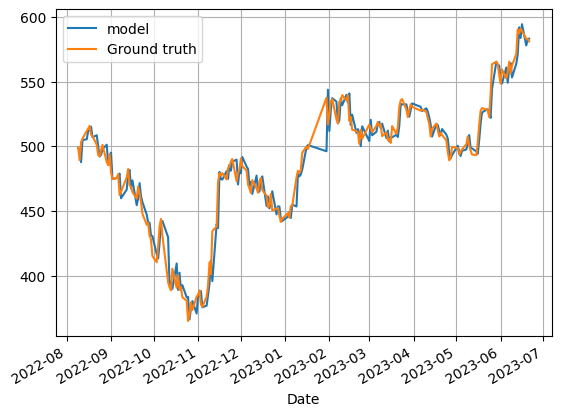

In [61]:
import pandas as pd

# 於測試資料上的圖表比較
predict_test = model.predict(x_test)
df = pd.DataFrame(predict_test, columns=['model'], index=data.index[n_day:][int(len(x)*split_ratio):])
df['Ground truth'] = y_test
print('日期區間', list(data.index[1:][int(len(x)*split_ratio):])[0], "~", list(data.index[1:][int(len(x)*split_ratio):])[-1])

ax = df.plot(grid=True, legend=True)
# 此模型進行預測時需要前一天的[開盤, 最高, 最低, 收盤, 調整收盤假, 成交量]等特徵，因此沒辦法預測**後天**的調整收盤假，
# 除非能夠預測未來的[開盤, 最高, 最低, 收盤, 調整收盤假, 成交量]等特徵或是只使用前一天的調整收盤假當作輸入特徵，否則此模型只能根據前一天的資訊預測明天的收盤調整假

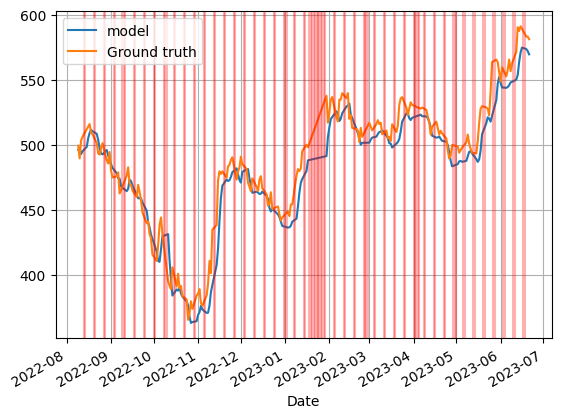

In [68]:
# 休市日期用紅線代表
from datetime import timedelta
import matplotlib.pyplot as pltplot
# 取出測試資料內所有日期
record_dates = data.index[n_day:][int(len(x)*split_ratio):]
empty_dates = []
start_date = record_dates[0]
end_date = record_dates[-1]
delta = timedelta(days=1)

# 找出被跳過的日期
while start_date <= end_date:
    if start_date not in record_dates:
        empty_dates.append(start_date)
    start_date += delta

# 在被跳過的日期劃上紅線
ax = df.plot(grid=True, legend=True)
for date in empty_dates:
    ax.axvline(x=date, color='red', alpha=0.3)

In [69]:
import numpy as np
print(data)
# 輸入資料 (Open, High, Low, Close, Adj Close, Volume) 以下範例為用 20230619 0620 0621 來預測 20230622
infr_x = np.array([583, 585, 582, 583, 583, 14346885]+[579, 585, 579, 583, 583, 16221413]+[582, 585, 578, 581, 581, 21703937]).reshape(1, -1)

# 模型預測隔天調整收盤假
pred = model.predict(infr_x)
print("預測隔天收盤假:", pred)

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2020-01-02  332.5  339.0  332.5  339.0  313.791595  31754120
2020-01-03  344.0  345.0  335.5  339.5  314.254364  41811268
2020-01-06  333.0  334.5  332.0  332.0  307.312225  45343057
2020-01-07  332.5  333.0  326.5  329.5  304.998047  50879181
2020-01-08  325.0  333.0  325.0  329.5  304.998047  37567748
...           ...    ...    ...    ...         ...       ...
2023-06-15  590.0  593.0  587.0  591.0  591.000000  27392154
2023-06-16  590.0  590.0  584.0  589.0  589.000000  38128802
2023-06-19  583.0  585.0  582.0  583.0  583.000000  14346885
2023-06-20  579.0  585.0  579.0  583.0  583.000000  16221413
2023-06-21  582.0  585.0  578.0  581.0  581.000000  21703937

[842 rows x 6 columns]
預測隔天收盤假: [3.6106642e+10]


In [70]:
# 嘗試其他模型
from sklearn.neural_network import MLPRegressor

# 使用多層 linear layer 的模型，看效果會不會比較好
model = MLPRegressor(hidden_layer_sizes=(100, 100, 100), solver="adam", verbose=True, learning_rate_init=5e-3, n_iter_no_change=1000, random_state=42, max_iter=3000)

# 訓練時對輸入做簡單的 normalize 讓模型比較好訓練
model.fit(x_train / x_train.sum(axis=0), y_train)

Iteration 1, loss = 122932.63874249
Iteration 2, loss = 122031.35163957
Iteration 3, loss = 120229.25603718
Iteration 4, loss = 116732.47419991
Iteration 5, loss = 110542.01544323
Iteration 6, loss = 100357.77795488
Iteration 7, loss = 85038.16470899
Iteration 8, loss = 63709.68375389
Iteration 9, loss = 38384.95670170
Iteration 10, loss = 15168.52305496
Iteration 11, loss = 6958.09160672
Iteration 12, loss = 14468.53146579
Iteration 13, loss = 12586.37800243
Iteration 14, loss = 7256.47511031
Iteration 15, loss = 6995.61254881
Iteration 16, loss = 8045.46378763
Iteration 17, loss = 7516.91621965
Iteration 18, loss = 6570.00950681
Iteration 19, loss = 6546.15924116
Iteration 20, loss = 6822.76820289
Iteration 21, loss = 6610.03957246
Iteration 22, loss = 6414.27964492
Iteration 23, loss = 6448.38412136
Iteration 24, loss = 6467.48393270
Iteration 25, loss = 6414.09139582
Iteration 26, loss = 6367.89896513
Iteration 27, loss = 6379.32555015
Iteration 28, loss = 6400.20219699
Iteration 2

MLPRegressor(hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.005,
             max_iter=3000, n_iter_no_change=1000, random_state=42,
             verbose=True)

In [71]:
# 計算訓練完的模型於訓練資料的 Mean squared error
train_x_pred = model.predict(x_train / x_train.sum(axis=0))
train_mse = (train_x_pred - y_train).T@(train_x_pred - y_train) / y_train.shape[0]
print("訓練資料MSE:", train_mse[0][0])
# 計算訓練完的模型於訓練資料的 Mean squared error
test_x_pred = model.predict(x_test / x_test.sum(axis=0))
test_mse = (test_x_pred - y_test).T@(test_x_pred - y_test) / y_test.shape[0]
print("測試資料MSE:", test_mse[0][0])
print("訓練資料漲跌一致率", (((x_train[:, -2] - y_train[:, 0]) > 0) == (x_train[:, -2] - train_x_pred > 0)).sum() / x_train.shape[0])
print("測試資料漲跌一致率:", (((x_test[:, -2] - y_test[:, 0]) > 0) == (x_test[:, -2] - test_x_pred > 0)).sum() / x_test.shape[0])

訓練資料MSE: 41332.71362042836
測試資料MSE: 896092.0387072128
訓練資料漲跌一致率 0.5230524642289348
測試資料漲跌一致率: 0.5


日期區間 2022-08-05 00:00:00 ~ 2023-06-21 00:00:00


<Axes: xlabel='Date'>

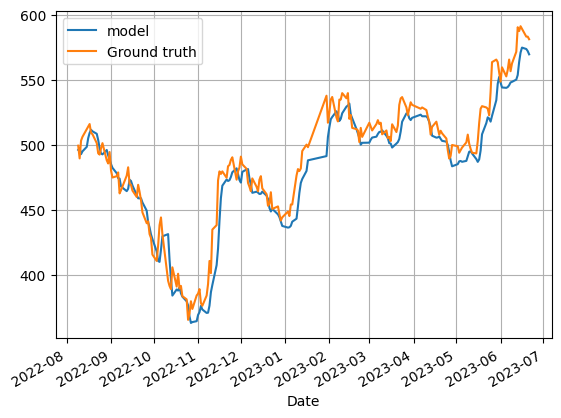

In [66]:
import pandas as pd

# 於測試資料上的圖表比較
predict_test = model.predict(x_test / x_train.sum(axis=0))
df = pd.DataFrame(predict_test, columns=['model'], index=data.index[n_day:][int(len(x)*split_ratio):])
df['Ground truth'] = y_test
print('日期區間', list(data.index[1:][int(len(x)*split_ratio):])[0], "~", list(data.index[1:][int(len(x)*split_ratio):])[-1])

df.plot(grid=True, legend=True)
# 雖然第二個模型可以學非線性的函數，但看起來第一個模型效果比較好
# 可能是非線性模型用梯度下降訓練，不容易找到最佳解的關係

In [67]:
import numpy as np
print(data)
# 輸入資料 (Open, High, Low, Close, Adj Close, Volume) 以下範例為用 20230619 0620 0621 來預測 20230622
infr_x = np.array([583, 585, 582, 583, 583, 14346885]+[579, 585, 579, 583, 583, 16221413]+[582, 585, 578, 581, 581, 21703937]).reshape(1, -1)

# 模型預測隔天調整收盤假
pred = model.predict(infr_x / x_train.sum(axis=0))
print("預測隔天收盤假:", pred)

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2020-01-02  332.5  339.0  332.5  339.0  313.791595  31754120
2020-01-03  344.0  345.0  335.5  339.5  314.254364  41811268
2020-01-06  333.0  334.5  332.0  332.0  307.312225  45343057
2020-01-07  332.5  333.0  326.5  329.5  304.998047  50879181
2020-01-08  325.0  333.0  325.0  329.5  304.998047  37567748
...           ...    ...    ...    ...         ...       ...
2023-06-15  590.0  593.0  587.0  591.0  591.000000  27392154
2023-06-16  590.0  590.0  584.0  589.0  589.000000  38128802
2023-06-19  583.0  585.0  582.0  583.0  583.000000  14346885
2023-06-20  579.0  585.0  579.0  583.0  583.000000  16221413
2023-06-21  582.0  585.0  578.0  581.0  581.000000  21703937

[842 rows x 6 columns]
預測隔天收盤假: [567.65819465]
